# Predicting House Prices using Linear Regression

In this notebook I will be predciting House Prices using Linear regression based on a number of features. The process to develop this model is shown below:
1. Extract the High Level Information about the dataset and explore dependent variable
2. Missing Value Handling
3. Feature Engineering
4. Handle Multicollinearity for Numerical Features
5. One-Hot Encoding + Alignment of Train/Test Data
6. LightGBM Model Training and CV Evaluation

### Import Relevant libraries

In [568]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold, cross_val_score
from lightgbm import LGBMRegressor
import seaborn as sns
import pandas as pd
import numpy as np

### Load the Data 

In [570]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 1. Extract the High Level Information about the dataset and explore dependent variable

In [572]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [573]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

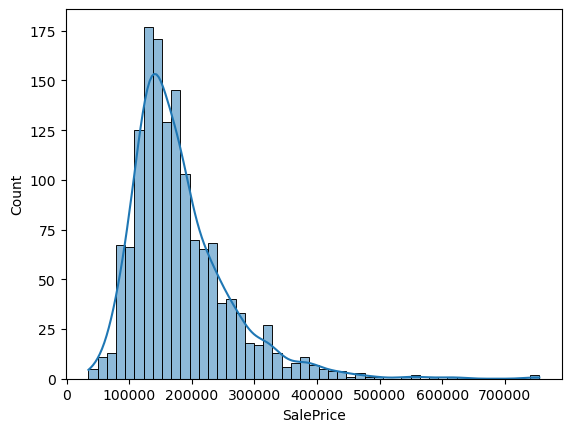

In [574]:
sns.histplot(train["SalePrice"], kde=True)  
train['SalePrice'].describe()  # We can see the sale prices of the houses are right (positively) skewed

<Axes: xlabel='SalePrice', ylabel='Count'>

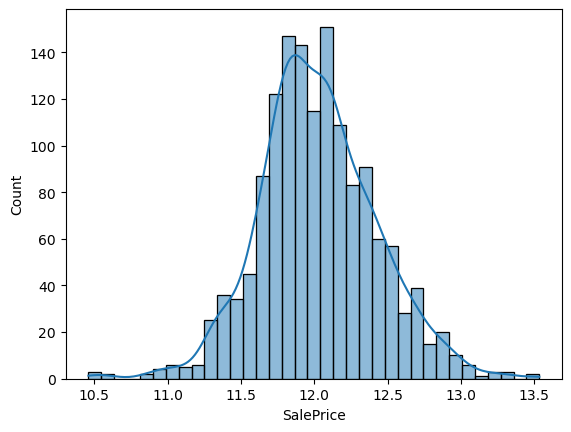

In [575]:
# To reduce skewed dependent varibale try log transformation 
sns.histplot(np.log1p(train["SalePrice"]), kde=True)

In [576]:
# Log transformation reduces skewness of house price data (we require normally distrubuted y value) so transform y using log transformation
y = np.log1p(train['SalePrice'])
train.drop(columns=['SalePrice'], inplace=True)

### 2. Missing Value Handling

In [578]:
def missing_values(df):
    # Fills missing numeric values with the median and categorical values with a placeholder.
    
    num_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(include=['object']).columns

    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    df[cat_cols] = df[cat_cols].fillna('NA')

    return df

In [579]:
# Missing Value Handling
train = missing_values(train)
test = missing_values(test)

### 3. Feature Engineering

In [581]:
def feature_engineering(df):
    # Adds domain-engineered features. If model_type='linear', removes redundant base features to prevent multicollinearity.

    # Add new features
    df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]  # Total square foot feature
    df["TotalBathrooms"] = (df["FullBath"] + 0.5 * df["HalfBath"] + df["BsmtFullBath"] + 0.5 * df["BsmtHalfBath"])  # Total bathrooms
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]  # Age of house feature
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]  # Age of remodel feature
    df["IsRemodeled"] = (df["YearBuilt"] != df["YearRemodAdd"]).astype(int)  # Boolean feature (if house is remodeled)
    df["TotalPorchSF"] = (df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"])
    df["HasGarage"] = (df["GarageArea"] > 0).astype(int)
    df["HasPool"] = (df["PoolArea"] > 0).astype(int)
    df["HasFireplace"] = (df["Fireplaces"] > 0).astype(int)
    df["OverallScore"] = df["OverallQual"] * df["OverallCond"]

    redundant = ["1stFlrSF", "2ndFlrSF", "TotalBsmtSF", "FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath", "YearBuilt", 
                 "YearRemodAdd", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "OverallQual", "OverallCond"]
    df.drop(columns=[c for c in redundant if c in df.columns], inplace=True)
    print(f"Dropped redundant features for linear model ({len(redundant)} columns).")

    return df

In [582]:
# Feature Engineering
train = feature_engineering(train)
test = feature_engineering(test)

Dropped redundant features for linear model (15 columns).
Dropped redundant features for linear model (15 columns).


### 4. Handle Multicollinearity for Numerical Features

In [584]:
def multicollinearity(df, threshold=0.85, vif_factor=10.0):
    df = df.copy()
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    df.drop(columns = to_drop, inplace=True, errors='ignore')

    while True:
        vif = pd.DataFrame()
        vif["Features"] = df.columns
        vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        max_vif = vif["VIF"].max()
        if max_vif > vif_factor:
            drop_col = vif.loc[vif["VIF"].idxmax(), "Features"]
            df.drop(columns=[drop_col], inplace=True)
        else:
            break
    return df

In [585]:
# Handle multicollinearity for numerical features
num_features = train.select_dtypes(include=["int64", "float64"]).columns  # We only want to handle the numerical columns
num_df_clean = multicollinearity(train[num_features], threshold=0.85, vif_factor=10.0)
train.drop(columns=num_features, inplace=True)
train = pd.concat([train, num_df_clean], axis=1)
train.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,Fireplaces,GarageCars,WoodDeckSF,PoolArea,MiscVal,MoSold,HouseAge,RemodAge,IsRemodeled,TotalPorchSF
0,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,0,2,0,0,0,2,5,5,0,61
1,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,1,2,298,0,0,5,31,31,0,0
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,1,2,0,0,0,9,7,6,1,42
3,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,1,3,0,0,0,2,91,36,1,307
4,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,1,3,192,0,0,12,8,8,0,84


### 4. One-Hot Encoding + Alignment of Train/Test Data

In [587]:
def encode_and_align(train_df, test_df):
    # Converts categorical features to one-hot encoded form and aligns train/test columns.

    train_enc = pd.get_dummies(train_df)
    test_enc = pd.get_dummies(test_df)
    train_enc, test_enc = train_enc.align(test_enc, join='left', axis=1)
    test_enc = test_enc.fillna(0)
    test_enc = test_enc[train_enc.columns]
    
    return train_enc, test_enc

In [588]:
# One-Hot Encoding + Alignment of Train/Test Data
train, test = encode_and_align(train, test)

### 5. LightGBM Model Training and CV Evaluation

In [590]:
def train_lightgbm(X, y):
    # Trains a LightGBM regressor with cross-validation and reports RMSE.

    parameters = {
        "n_estimators": 5500,
        "learning_rate": 0.01,
        "num_leaves": 40,
        "feature_fraction": 0.5,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
        "random_state": 42,
    }
    model = LGBMRegressor(**parameters)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = -cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv=kf)

    print(f"Cross Validation RMSE: {scores.mean():.5f} ± {scores.std():.5f}")
    
    return model

In [591]:
# Train model and report CV RMSE
lgb_model = train_lightgbm(train, y)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

In [592]:
# Refit model on the full training data
lgb_model.fit(train, y)

# Generate predictions on the test set
test_preds_log = lgb_model.predict(test)

# Inverse transform to get real SalePrice (undo log1p)
test_preds = np.expm1(test_preds_log)

# Create submission file
submission = pd.DataFrame({
    "Id": test["Id"],          # ensure the ID column matches your test file
    "SalePrice": test_preds
})

# Save to CSV
submission.to_csv("submission.csv", index=False)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru